
# First Task: Segmentaion (Regression Task)
### Heart Sound Segmentation
- The first challenge is to produce a method that can locate S1 (LUB) and S2 (DUB)
sounds within audio data, segmenting the Normal audio files.


In [68]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import  random
import numpy as np
import os
import glob
import wave
import struct
from scipy.io import wavfile
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LSTM, Bidirectional
from keras.layers import Convolution2D, Conv2D, Conv1D, MaxPooling2D, MaxPool1D , GlobalAveragePooling2D, MaxPooling1D, GlobalAveragePooling1D, InputLayer

In [2]:
drive.mount('/gdrive', force_remount = True)
!ln -s "/gdrive/MyDrive/HeartBeats/set_a" "/content/set_a"
!ln -s "/gdrive/MyDrive/HeartBeats/set_a_timing.csv" "/content/set_a_timing.csv"
!ln -s "/gdrive/MyDrive/HeartBeats/set_a.csv" "/content/set_a.csv"
seta_a_timing_path = "/content/set_a_timing.csv"
seta_path = "/content/set_a"

Mounted at /gdrive


### Reading "set_a_timing.csv" into a dataframe

In [3]:
df = pd.read_csv(seta_a_timing_path)
df

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992
...,...,...,...,...
385,set_a/normal__201108011118.wav,10,S2,284673
386,set_a/normal__201108011118.wav,11,S1,300863
387,set_a/normal__201108011118.wav,11,S2,314279
388,set_a/normal__201108011118.wav,12,S1,330980


### Creating a df for the cut of each cycle 

In [236]:
timing = pd.DataFrame(columns=['fname', 'cycle','start_loc', 'end_loc','S1','S2'])
index = 0
timing

,fname,cycle,start_loc,end_loc,S1,S2


#### Cutting each cycle such as it contains its LUB and DUB:
1. It will start at a random value between its LUB and the previous DUB
2. It will end at a random value between its DUB and the next LUB
3. This is to prevent feeding the model the location of the LUB and DUB ready for extraction.

In [237]:
end_prev = 0
for i in range(len(df)):
  cycle = df.iloc[i]['cycle']
  fname = df.iloc[i]['fname']
  
  if df.iloc[i]['sound'] == 'S1':
    location_S1 = df.iloc[i]['location']
    # this condition is if we are not reading the first instance in set_a_timing, so we get the previous DUB
    if i != 0 :
      # if it is not the same as the previous file, we reset the end_prev
      if fname != df.iloc[i-1]['fname']:
          end_prev = 0
      else: 
        end_prev = df.iloc[i-1]['location']
    
    # cut the first cycle at a random number between the previous DUB and the current LUB
    if location_S1 < end_prev:
        start_cycle = random.randint(location_S1, end_prev)
    else:
        start_cycle = random.randint(end_prev, location_S1)
    # add the start of the cut and the location of S1 in the df for later use
    timing.loc[index, ['fname','cycle','start_loc','S1']] = [fname, cycle, start_cycle, location_S1] 

  # end with cutting after S2
  if df.iloc[i]['sound']  == 'S2':
    location_S2 = df.iloc[i]['location']
    # this condition is if we are not reading the last instance in set_a_timing, so we get the next LUB
    if i != len(df) - 1:
        start_next = df.iloc[i+1]['location']
         # if it is not the same as the next file, we set the next LUB with a random value between the current DUB and the maximum value  
        if fname != df.iloc[i+1]['fname']:
            start_next =  random.randint(location_S2, 396900)
    else:
        # if it is the last instance, we set the next LUB with a random value between the current DUB and the maximum value  
        start_next =  random.randint(location_S2, 396900) 
        
    
    # getting the value of the end of the cut which is a random value between the current DUB and the next LUB
    if location_S2 < start_next:
        end_prev = random.randint(location_S2, start_next)
    else:
        end_prev = random.randint(start_next, location_S2)

    # add the end of the cut and the location of S2 for future use
    timing.loc[index, ['end_loc','S2']] = [end_prev,location_S2] 
    index = index + 1

In [238]:
timing

,fname,cycle,start_loc,end_loc,S1,S2
0,set_a/normal__201102081321.wav,1,380,30427,10021,20759
1,set_a/normal__201102081321.wav,2,34640,49088,35075,47244
2,set_a/normal__201102081321.wav,3,58937,76921,62992,73729
3,set_a/normal__201102081321.wav,4,74934,105258,88761,101646
4,set_a/normal__201102081321.wav,5,112243,142695,115246,127415
...,...,...,...,...,...,...
190,set_a/normal__201108011118.wav,8,199619,238946,213315,226220
191,set_a/normal__201108011118.wav,9,227631,260819,241403,255826
192,set_a/normal__201108011118.wav,10,260360,292639,272527,284673
193,set_a/normal__201108011118.wav,11,288205,315809,300863,314279


***NOTE***
> We tried running the above code that creates the splits randomly multiple times to increase the size of the data as a type of data augmentation due to the randomness, but it didn't affect the MSE at all, so we figured that the 195 splits were enough for the regression task.



### Splitting the audio files with the cut locations for each cyle that we obtained earlier:



In [239]:
# we will save the names of the new audio files in this array
cycle_files = []

for i in range(len(timing)):
    rate, data = wavfile.read(timing['fname'][i])
    # times between which to extract the wave from
    start = timing['start_loc'][i]/rate # seconds
    end = timing['end_loc'][i]/rate # seconds
    # file to extract the snippet from
    with wave.open(timing['fname'][i], "rb") as infile:
        # get file data
        nchannels = infile.getnchannels()
        sampwidth = infile.getsampwidth()
        framerate = infile.getframerate()
        # set position in wave to start of segment
        infile.setpos(timing['start_loc'][i])
        # extract data
        data = infile.readframes(timing['end_loc'][i] - timing['start_loc'][i])
    # write the extracted data to a new file
    new_file = 'file' + str(i) + '.wav'
    with wave.open(new_file, 'w') as outfile:
        outfile.setnchannels(nchannels)
        outfile.setsampwidth(sampwidth)
        outfile.setframerate(framerate)
        outfile.setnframes(int(len(data) / sampwidth))
        outfile.writeframes(data)
    
    cycle_files.append(new_file)

print(cycle_files)

['file0.wav', 'file1.wav', 'file2.wav', 'file3.wav', 'file4.wav', 'file5.wav', 'file6.wav', 'file7.wav', 'file8.wav', 'file9.wav', 'file10.wav', 'file11.wav', 'file12.wav', 'file13.wav', 'file14.wav', 'file15.wav', 'file16.wav', 'file17.wav', 'file18.wav', 'file19.wav', 'file20.wav', 'file21.wav', 'file22.wav', 'file23.wav', 'file24.wav', 'file25.wav', 'file26.wav', 'file27.wav', 'file28.wav', 'file29.wav', 'file30.wav', 'file31.wav', 'file32.wav', 'file33.wav', 'file34.wav', 'file35.wav', 'file36.wav', 'file37.wav', 'file38.wav', 'file39.wav', 'file40.wav', 'file41.wav', 'file42.wav', 'file43.wav', 'file44.wav', 'file45.wav', 'file46.wav', 'file47.wav', 'file48.wav', 'file49.wav', 'file50.wav', 'file51.wav', 'file52.wav', 'file53.wav', 'file54.wav', 'file55.wav', 'file56.wav', 'file57.wav', 'file58.wav', 'file59.wav', 'file60.wav', 'file61.wav', 'file62.wav', 'file63.wav', 'file64.wav', 'file65.wav', 'file66.wav', 'file67.wav', 'file68.wav', 'file69.wav', 'file70.wav', 'file71.wav', '



---



### Helper Functions:

#### Get the maximum length of the MFCC extraction to pad with later:

In [240]:
MAX_LEN_MFCC = []

for file in cycle_files:
    audio,sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    MAX_LEN_MFCC.append(mfccs.shape[1])

print(max(MAX_LEN_MFCC))

137


#### Extracting the features using MFCC:
(like we did in the classification part)

In [241]:
from tqdm import tqdm
def extract_features(data):
  X = []
  for i in tqdm(range(len(data))):
    filename = data[i]
    try:
      y, sr = librosa.load(filename, res_type='kaiser_fast')  
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
      pad_width = max(MAX_LEN_MFCC) - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
      X.append(mfccs)  
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 

  return X

#### Compiling and fitting: (we are using **MSE** as our evaluation metric)

In [200]:
def compile_fit(model, lossfn ='mean_squared_error', LR = 0.001, epoch_no=150):
    adam = keras.optimizers.Adam(learning_rate=LR)
    model.compile(optimizer='adam', loss=lossfn)
    filepath="/content/weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history = model.fit(x_train, y_train,
          batch_size=50,
          epochs=epoch_no,
          verbose=1,
          validation_data=(x_val, y_val), 
          shuffle=True,
          callbacks = [checkpoint])
    adam = keras.optimizers.Adam(learning_rate=LR)
    model.load_weights("/content/weights.best.hdf5")
    model.compile(loss=lossfn, optimizer='adam')
    print("Created model and loaded weights from file")
    return history, model

#### Getting the MSE of the training and validation data:

In [11]:
def train_val_evaluation(model,results,index):
  train_mse = model.evaluate(x_train, y_train, verbose=0)
  print('Train MSE:', train_mse)
  val_mse = model.evaluate(x_val, y_val, verbose=0)
  print('Validation MSE:', val_mse)
  results.loc[index,['Train MSE','Validation MSE']] = [train_mse, val_mse]

#### Evaluating the model using testing data:

In [12]:
def test_evaluation(model, y_pred,results,index):
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test MSE:', score)
  rms = mean_squared_error(y_test, y_pred, squared=False)
  print('Test RMSE:', rms)
  MAE = mean_absolute_error(y_test, y_pred)
  print('Test MAE:', MAE)
  results.loc[index,['Test MSE', 'Test RMSE', 'Test MAE']] = [score, rms,MAE]

#### Plotting the predicted values of LUB and DUB locations VS the original:

In [105]:
def plot_LUB_DUB(y_test, y_pred):
  x_ax = range(len(y_pred))
  fig = plt.figure()
  plt.subplot(2, 1, 1)
  plt.scatter(x_ax, y_test[:,0], s=5, color="blue", label="original")
  plt.plot(x_ax, y_pred[:,0], lw=0.8, color="red", label="predicted")
  plt.legend()
  plt.title('LUB')
  plt.ylim(-1, 1)
  plt.subplot(2, 1, 2)
  plt.scatter(x_ax, y_test[:,1], s=5, color="blue", label="original")
  plt.plot(x_ax, y_pred[:,1], lw=0.8, color="red", label="predicted")
  plt.legend()
  plt.title('DUB')
  plt.ylim(0, 2)
  plt.show()



---



### Feature extraction on the cutted locations we got:

In [242]:
features = extract_features(cycle_files)

100%|██████████| 195/195 [00:04<00:00, 44.10it/s]


### Creating the labels for our cut audio files], which contain the location of the LUB and DUB for each cycle (each cutted file):

####***Normalising the locations (MIN - MAX Normalisation):***

In [243]:
y = []
for i in range(len(timing)):
    S1 = timing['S1'][i]
    S2 = timing['S2'][i]
    cut_start = timing['start_loc'][i]
    cut_end = timing['end_loc'][i]
    diff = cut_end - cut_start
    LUB = (S1 - cut_start ) / diff 
    DUB = (S2 - cut_start) / diff 
    y_i = [LUB, DUB]
    y.append(y_i)

print(y)

[[0.3208639797650348, 0.6782374280294206], [0.03010797342192691, 0.8723698781838317], [0.2254782028469751, 0.822508896797153], [0.45597546497823505, 0.8808864265927978], [0.09861421253119663, 0.4982267174569815], [0.2786102576223115, 0.7861498463720161], [0.1533238165052664, 0.6228249546664609], [0.3794794831435997, 0.7725392583915955], [0.04689974659486855, 0.2736379474184352], [0.18326257558214332, 0.9199794159269266], [0.37379935965848454, 0.6793756670224119], [0.25240721877342354, 0.45876496703888064], [0.0928873665121902, 0.6441332527369199], [0.35800292708887704, 0.8890699840340607], [0.28696768671089234, 0.7598170340252515], [0.05851967412029815, 0.7306292251690067], [0.17531009409751924, 0.5005168234958655], [0.6799802429222515, 0.9744505062751173], [0.0368432526705908, 0.5548288641813822], [0.04368402286307009, 0.19448736372378472], [0.09426339886883921, 0.9201454349582547], [0.148551422881737, 0.5671291835292606], [0.009575271166911677, 0.49692081528864873], [0.21308010221787

In [221]:
print(len(y))

195


### Splitting the data and labels with ratio **70:15:15** into train, test, and validation splits respectively:

In [244]:
# splitting to get test partition
x_train_1, x_test, y_train_1, y_test = train_test_split(features, y, test_size=0.15, random_state=42)
# splitting to get validation and training partition (0.15/0.85)
x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, test_size=0.17647059 , random_state=42)

In [245]:
print(f"Training Data Size:  {len(x_train)}")
print(f"Validation Data Size:  {len(x_val)}")
print(f"Testing Data Size:  {len(x_test)}")

Training Data Size:  135
Validation Data Size:  30
Testing Data Size:  30


In [246]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
print("X train:", x_train.shape)
print("X test:", x_test.shape)
print("X validation:", x_val.shape)
print("Y train:", y_train.shape)
print("Y test:", y_test.shape)
print("Y validation:", y_val.shape)

X train: (135, 40, 137)
X test: (30, 40, 137)
X validation: (30, 40, 137)
Y train: (135, 2)
Y test: (30, 2)
Y validation: (30, 2)


In [247]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
# set aside for testing 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [248]:
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X val:", x_val.shape)
print("Y val:", y_val.shape)
# set aside for testing 
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (135, 40, 137, 1)
Y train: (135, 2)
X val: (30, 40, 137, 1)
Y val: (30, 2)
X test: (30, 40, 137, 1)
Y test: (30, 2)


In [249]:
results = pd.DataFrame(columns=['Architecture', 'LR','Dropout and pooling', 'kernel size','Loss Fn', 'Train MSE','Validation MSE', 'Test MSE', 'Test RMSE', 'Test MAE'])
index = 0
results

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE


***NOTES***
* In regression you are estimating the parameters. So, you can’t say an estimated value completely wrong or completely right, but you can only say how far or near it is to the original value. You won’t have absolute class labels to compare it with output. So, Loss (error) is the only measure to analyze the performance of regression. 

*  For regression it is best practice to use the Mean Squared Error as loss function. 


# CNN Experiment 1:

In [250]:
model = Sequential()
model.add(Conv2D(16,(1, 1), padding = 'same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(Conv2D(32, (1, 1), padding = 'same',activation='relu'))
model.add(Conv2D(64, (1, 1),padding = 'same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (1, 1),padding = 'same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 40, 137, 16)       32        
                                                                 
 conv2d_69 (Conv2D)          (None, 40, 137, 32)       544       
                                                                 
 conv2d_70 (Conv2D)          (None, 40, 137, 64)       2112      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 20, 68, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 20, 68, 128)       8320      
                                                                 
 global_average_pooling2d_24  (None, 128)              0         
  (GlobalAveragePooling2D)                           

In [251]:
history, model = compile_fit(model, epoch_no=200, LR=0.0001)

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.7298
Epoch 1: val_loss improved from inf to 0.23349, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 440ms/step - loss: 0.7298 - val_loss: 0.2335
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.1606
Epoch 2: val_loss improved from 0.23349 to 0.07599, saving model to /content/weights.best.hdf5
3/3 [==============================] - 1s 394ms/step - loss: 0.1606 - val_loss: 0.0760
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.1152
Epoch 3: val_loss did not improve from 0.07599
3/3 [==============================] - 1s 391ms/step - loss: 0.1152 - val_loss: 0.1498
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.1865
Epoch 4: val_loss did not improve from 0.07599
3/3 [==============================] - 1s 378ms/step - loss: 0.1865 - val_loss: 0.1345
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.1464
Ep

In [252]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['CNN 2D','No Dropout Layers, 1 max-pooling layer', '1','Mean-Squared-Error',0.0001] 

#### Train & Validation **(MSE)**

In [253]:
train_val_evaluation(model,results,index)

Train MSE: 0.02108066715300083
Validation MSE: 0.01834106259047985


#### Prediction

In [259]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 60ms/step
[[0.24043328 0.57956964]
 [0.36715806 0.5554594 ]
 [0.22881249 0.7685761 ]
 [0.20147689 0.8025401 ]
 [0.20391342 0.7982108 ]
 [0.24343888 0.74127674]
 [0.28203288 0.711034  ]
 [0.2770047  0.71082526]
 [0.28977522 0.6735199 ]
 [0.30523026 0.6412763 ]
 [0.24447604 0.7208286 ]
 [0.2679377  0.72319394]
 [0.21072768 0.7811976 ]
 [0.19379094 0.8089655 ]
 [0.26857552 0.6664924 ]
 [0.3183451  0.6121762 ]
 [0.22101872 0.7505463 ]
 [0.24382125 0.7420179 ]
 [0.23870173 0.73090905]
 [0.24877693 0.6665857 ]
 [0.22581148 0.69809157]
 [0.23311587 0.72363514]
 [0.35257176 0.57872695]
 [0.21469532 0.7582124 ]
 [0.2759349  0.6554795 ]
 [0.24199612 0.7589164 ]
 [0.4278046  0.45006335]
 [0.2289663  0.691682  ]
 [0.2686008  0.69114643]
 [0.23045132 0.7291513 ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

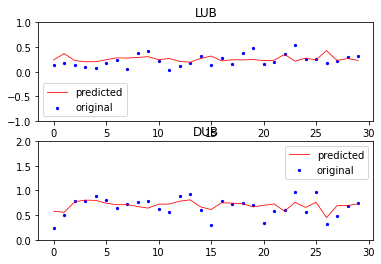

In [260]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**): 


In [261]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.019292153418064117
Test RMSE: 0.13870513968964437
Test MAE: 0.10601457158735089


In [257]:
index = index + 1
results 

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015


## CNN Experiment 2:
### Changing in Parameters and Architecture: 

In [274]:
model = Sequential()
model.add(Conv2D(16,(2, 2), padding = 'same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2, 2), padding = 'same',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2, 2),padding = 'same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (2, 2),padding = 'same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='linear', kernel_regularizer='l2'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 40, 137, 16)       80        
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 20, 68, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 20, 68, 32)        2080      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 10, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 10, 34, 64)        8256      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 5, 17, 64)      

In [275]:
history , model = compile_fit(model, epoch_no=300, LR=0.001)

Epoch 1/300
3/3 [==============================] - ETA: 0s - loss: 0.3065
Epoch 1: val_loss improved from inf to 0.17241, saving model to /content/weights.best.hdf5
3/3 [==============================] - 1s 242ms/step - loss: 0.3065 - val_loss: 0.1724
Epoch 2/300
3/3 [==============================] - ETA: 0s - loss: 0.2063
Epoch 2: val_loss improved from 0.17241 to 0.10493, saving model to /content/weights.best.hdf5
3/3 [==============================] - 1s 175ms/step - loss: 0.2063 - val_loss: 0.1049
Epoch 3/300
3/3 [==============================] - ETA: 0s - loss: 0.1256
Epoch 3: val_loss did not improve from 0.10493
3/3 [==============================] - 1s 167ms/step - loss: 0.1256 - val_loss: 0.1424
Epoch 4/300
3/3 [==============================] - ETA: 0s - loss: 0.1368
Epoch 4: val_loss did not improve from 0.10493
3/3 [==============================] - 1s 171ms/step - loss: 0.1368 - val_loss: 0.1105
Epoch 5/300
3/3 [==============================] - ETA: 0s - loss: 0.1097
Ep

In [278]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['CNN 2D','No Dropout Layers, 3 max-pooling layers', 2, 'Mean-Squared-Error', 0.0001] 

#### Train & Validation **(MSE)**


In [279]:
train_val_evaluation(model,results,index)

Train MSE: 0.006355891469866037
Validation MSE: 0.02295304648578167


#### Prediction

In [276]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 93ms/step
[[0.31032667 0.28322095]
 [0.33963287 0.64571655]
 [0.2864222  0.82364225]
 [0.19179119 0.8041955 ]
 [0.1162512  0.8136891 ]
 [0.30992642 0.8208827 ]
 [0.37431777 0.8005483 ]
 [0.20197259 0.6782805 ]
 [0.34682342 0.7257631 ]
 [0.3540831  0.61406744]
 [0.2823682  0.7141821 ]
 [0.19975479 0.72082984]
 [0.21944126 0.8177727 ]
 [0.05056515 0.705973  ]
 [0.3092994  0.5709652 ]
 [0.36490273 0.61080337]
 [0.11614383 0.6703699 ]
 [0.33772257 0.8458569 ]
 [0.22237131 0.6096601 ]
 [0.4303692  0.6362823 ]
 [0.35624743 0.661567  ]
 [0.19967681 0.6034355 ]
 [0.3803001  0.65420425]
 [0.15955134 0.69636244]
 [0.3486653  0.6244632 ]
 [0.1831757  0.751526  ]
 [0.51632273 0.6570137 ]
 [0.3714193  0.6742134 ]
 [0.2535278  0.6595578 ]
 [0.22824517 0.6778088 ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

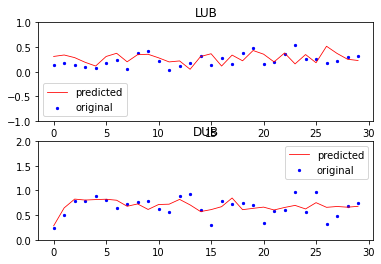

In [277]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**): 

In [280]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.027629105374217033
Test RMSE: 0.15296251439532638
Test MAE: 0.1232626470469733


***COMMENTS***
> Overfitting was observed.

In [281]:
index = index + 1
results 

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015
1,CNN 2D,0.0001,"No Dropout Layers, 3 max-pooling layers",2,Mean-Squared-Error,0.006356,0.022953,0.027629,0.152963,0.123263




---



## ANN Experiment 1:

In [282]:
from keras.layers import BatchNormalization
model = Sequential()


model.add(Dense(64, input_shape=(x_train[1].shape)))
model.add(BatchNormalization())
model.add(Activation('relu'))
 
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
   
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 40, 137, 64)       128       
                                                                 
 batch_normalization_16 (Bat  (None, 40, 137, 64)      256       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 40, 137, 64)       0         
                                                                 
 dense_58 (Dense)            (None, 40, 137, 32)       2080      
                                                                 
 batch_normalization_17 (Bat  (None, 40, 137, 32)      128       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 40, 137, 32)     

In [283]:
history , model = compile_fit(model, epoch_no=350)

Epoch 1/350
3/3 [==============================] - ETA: 0s - loss: 0.2766
Epoch 1: val_loss improved from inf to 0.33637, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 613ms/step - loss: 0.2766 - val_loss: 0.3364
Epoch 2/350
3/3 [==============================] - ETA: 0s - loss: 0.2044
Epoch 2: val_loss improved from 0.33637 to 0.31337, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 531ms/step - loss: 0.2044 - val_loss: 0.3134
Epoch 3/350
3/3 [==============================] - ETA: 0s - loss: 0.1613
Epoch 3: val_loss improved from 0.31337 to 0.30053, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 529ms/step - loss: 0.1613 - val_loss: 0.3005
Epoch 4/350
3/3 [==============================] - ETA: 0s - loss: 0.1334
Epoch 4: val_loss improved from 0.30053 to 0.28379, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 533ms/step - loss: 0.1334

In [284]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['ANN','1 Dropout','-', 'Mean-Squared-Error',0.001] 

#### Train & Validation **(MSE)**:




In [285]:
train_val_evaluation(model,results,index)

Train MSE: 0.02047724835574627
Validation MSE: 0.018904920667409897


#### Prediction:

In [286]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 196ms/step
[[0.29583746 0.48856193]
 [0.3730145  0.5952381 ]
 [0.24772766 0.75889057]
 [0.21755834 0.80101806]
 [0.2204832  0.79228556]
 [0.26260203 0.73489666]
 [0.27672786 0.73002213]
 [0.2843376  0.7212192 ]
 [0.28988606 0.6987757 ]
 [0.30064964 0.6754122 ]
 [0.27312085 0.6589951 ]
 [0.27706957 0.7338234 ]
 [0.22735491 0.7776133 ]
 [0.21491729 0.79126173]
 [0.29872084 0.59360486]
 [0.31803113 0.64036274]
 [0.23935586 0.7497056 ]
 [0.2533268  0.74484795]
 [0.26767647 0.66876906]
 [0.28747535 0.6469855 ]
 [0.2662441  0.6699539 ]
 [0.26259607 0.68251413]
 [0.34924787 0.6424787 ]
 [0.23687625 0.76269937]
 [0.30624622 0.5853674 ]
 [0.244952   0.7701974 ]
 [0.42216945 0.54274476]
 [0.25597084 0.66767174]
 [0.2833143  0.6980539 ]
 [0.24744555 0.737696  ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

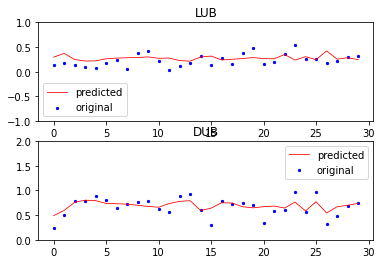

In [287]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**): 


In [288]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.01861623115837574
Test RMSE: 0.13640088687170343
Test MAE: 0.10659443330928323


In [289]:
index = index + 1
results 

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015
1,CNN 2D,0.0001,"No Dropout Layers, 3 max-pooling layers",2,Mean-Squared-Error,0.006356,0.022953,0.027629,0.152963,0.123263
2,ANN,0.001,1 Dropout,-,Mean-Squared-Error,0.020477,0.018905,0.018616,0.136401,0.106594


## ANN Experiment 2:
### Changing in parameters and Architecture:

In [290]:
model = Sequential()

model.add(Dense(64, input_shape=(x_train[1].shape)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
  
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(GlobalAveragePooling2D())

model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 40, 137, 64)       128       
                                                                 
 batch_normalization_18 (Bat  (None, 40, 137, 64)      256       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 40, 137, 64)       0         
                                                                 
 dropout_18 (Dropout)        (None, 40, 137, 64)       0         
                                                                 
 dense_62 (Dense)            (None, 40, 137, 32)       2080      
                                                                 
 batch_normalization_19 (Bat  (None, 40, 137, 32)      128       
 chNormalization)                                    

In [291]:
history , model = compile_fit(model)

Epoch 1/150
3/3 [==============================] - ETA: 0s - loss: 0.2243
Epoch 1: val_loss improved from inf to 0.40077, saving model to /content/weights.best.hdf5
3/3 [==============================] - 3s 854ms/step - loss: 0.2243 - val_loss: 0.4008
Epoch 2/150
3/3 [==============================] - ETA: 0s - loss: 0.1661
Epoch 2: val_loss improved from 0.40077 to 0.31173, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 746ms/step - loss: 0.1661 - val_loss: 0.3117
Epoch 3/150
3/3 [==============================] - ETA: 0s - loss: 0.1200
Epoch 3: val_loss improved from 0.31173 to 0.25612, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 751ms/step - loss: 0.1200 - val_loss: 0.2561
Epoch 4/150
3/3 [==============================] - ETA: 0s - loss: 0.0840
Epoch 4: val_loss improved from 0.25612 to 0.21416, saving model to /content/weights.best.hdf5
3/3 [==============================] - 2s 764ms/step - loss: 0.0840

In [292]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['ANN','3 Dropout','-', 'Mean-Squared-Error',0.001] 

#### Train & Validation **(MSE)**


In [293]:
train_val_evaluation(model,results,index)

Train MSE: 0.020909827202558517
Validation MSE: 0.019591396674513817


#### Prediction:

In [294]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 196ms/step
[[0.28429586 0.46421984]
 [0.36351395 0.5999014 ]
 [0.24575002 0.7331689 ]
 [0.21499117 0.77705   ]
 [0.21764717 0.7694079 ]
 [0.25970864 0.71212   ]
 [0.27166116 0.7287889 ]
 [0.27990648 0.7106253 ]
 [0.28273174 0.70231473]
 [0.2922439  0.6835389 ]
 [0.26964554 0.63639736]
 [0.27266008 0.7220092 ]
 [0.22406854 0.75446224]
 [0.21228302 0.7653375 ]
 [0.29308215 0.5764994 ]
 [0.30899927 0.6487132 ]
 [0.23424566 0.72946644]
 [0.2493598  0.72976893]
 [0.26471132 0.6449088 ]
 [0.2833364  0.6144151 ]
 [0.26271963 0.63319755]
 [0.258252   0.6612338 ]
 [0.3365828  0.65929794]
 [0.23231974 0.73654914]
 [0.30082485 0.56914854]
 [0.24027373 0.75990134]
 [0.4052167  0.57939017]
 [0.2493516  0.643768  ]
 [0.27595124 0.69212747]
 [0.24188681 0.7198883 ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

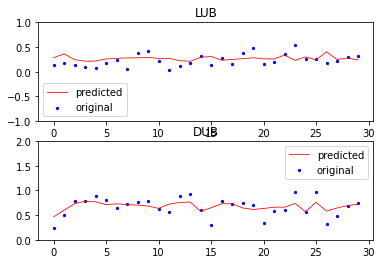

In [295]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**):

In [296]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.01867247372865677
Test RMSE: 0.13652767766291463
Test MAE: 0.10843760628038127


In [297]:
index = index +1
results

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015
1,CNN 2D,0.0001,"No Dropout Layers, 3 max-pooling layers",2,Mean-Squared-Error,0.006356,0.022953,0.027629,0.152963,0.123263
2,ANN,0.001,1 Dropout,-,Mean-Squared-Error,0.020477,0.018905,0.018616,0.136401,0.106594
3,ANN,0.001,3 Dropout,-,Mean-Squared-Error,0.02091,0.019591,0.018672,0.136528,0.108438


## RNN Experiment 1:

In [303]:
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 64)            51712     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_67 (Dense)            (None, 2)                 66        
                                                                 
Total params: 64,194
Trainable params: 64,194
Non-trainable params: 0
_________________________________________________________________


In [305]:
history , model = compile_fit(model, epoch_no=300, LR=0.0001)

Epoch 1/300
3/3 [==============================] - ETA: 0s - loss: 0.0014
Epoch 1: val_loss improved from inf to 0.02707, saving model to /content/weights.best.hdf5
3/3 [==============================] - 5s 357ms/step - loss: 0.0014 - val_loss: 0.0271
Epoch 2/300
3/3 [==============================] - ETA: 0s - loss: 0.0020
Epoch 2: val_loss improved from 0.02707 to 0.02608, saving model to /content/weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 0.0020 - val_loss: 0.0261
Epoch 3/300
3/3 [==============================] - ETA: 0s - loss: 0.0017
Epoch 3: val_loss did not improve from 0.02608
3/3 [==============================] - 0s 113ms/step - loss: 0.0017 - val_loss: 0.0263
Epoch 4/300
3/3 [==============================] - ETA: 0s - loss: 9.3739e-04
Epoch 4: val_loss did not improve from 0.02608
3/3 [==============================] - 0s 120ms/step - loss: 9.3739e-04 - val_loss: 0.0267
Epoch 5/300
3/3 [==============================] - ETA: 0s - loss: 0

In [306]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['RNN',0.05,'-', 'Mean-Squared-Error',0.0001] 

#### Train & Validation **(MSE)**:


In [307]:
train_val_evaluation(model,results,index)

Train MSE: 8.706280641490594e-05
Validation MSE: 0.018935399129986763


#### Prediction:

In [308]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 1s 667ms/step
[[0.25242016 0.5425881 ]
 [0.24906209 0.5870044 ]
 [0.2078066  0.6763939 ]
 [0.06431777 0.877593  ]
 [0.0594763  0.7706892 ]
 [0.3429276  0.82828355]
 [0.22001083 0.685735  ]
 [0.27284026 0.7231954 ]
 [0.2507504  0.6454253 ]
 [0.39364287 0.70894945]
 [0.21051621 0.69240767]
 [0.35239586 0.76451576]
 [0.11021812 0.76765203]
 [0.23999202 0.795769  ]
 [0.35446116 0.72906554]
 [0.29338303 0.6332439 ]
 [0.28501216 0.80103844]
 [0.29444596 0.8289521 ]
 [0.24303758 0.62647474]
 [0.35460445 0.71329105]
 [0.26997325 0.61462694]
 [0.2687757  0.6425773 ]
 [0.39234102 0.6932895 ]
 [0.2590944  0.75657094]
 [0.33396015 0.6657334 ]
 [0.27994516 0.81484157]
 [0.33281913 0.7833489 ]
 [0.27048033 0.5904684 ]
 [0.3054619  0.7037455 ]
 [0.3186404  0.7577348 ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

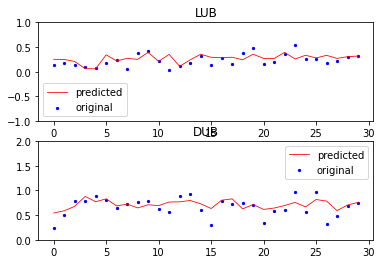

In [309]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**):

In [310]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.020013730973005295
Test RMSE: 0.13995665195260448
Test MAE: 0.10637048588601006


***COMMENTS***
> Overfitting was **highly** observed.

In [311]:
index = index +1
results

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015
1,CNN 2D,0.0001,"No Dropout Layers, 3 max-pooling layers",2,Mean-Squared-Error,0.006356,0.022953,0.027629,0.152963,0.123263
2,ANN,0.001,1 Dropout,-,Mean-Squared-Error,0.020477,0.018905,0.018616,0.136401,0.106594
3,ANN,0.001,3 Dropout,-,Mean-Squared-Error,0.02091,0.019591,0.018672,0.136528,0.108438
4,RNN,0.0001,0.05,-,Mean-Squared-Error,0.000087,0.018935,0.020014,0.139957,0.10637


## RNN Experiment 2:
### Changed in Architecture

In [323]:
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=True))
model.add(LSTM(units=16, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(2, activation='linear'))
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 40, 64)            51712     
                                                                 
 lstm_15 (LSTM)              (None, 40, 32)            12416     
                                                                 
 lstm_16 (LSTM)              (None, 16)                3136      
                                                                 
 dense_72 (Dense)            (None, 2)                 34        
                                                                 
Total params: 67,298
Trainable params: 67,298
Non-trainable params: 0
_________________________________________________________________


In [324]:
history , model = compile_fit(model, epoch_no=700, LR=0.0001)

Epoch 1/700
3/3 [==============================] - ETA: 0s - loss: 0.2639
Epoch 1: val_loss improved from inf to 0.21207, saving model to /content/weights.best.hdf5
3/3 [==============================] - 10s 556ms/step - loss: 0.2639 - val_loss: 0.2121
Epoch 2/700
3/3 [==============================] - ETA: 0s - loss: 0.1680
Epoch 2: val_loss improved from 0.21207 to 0.14320, saving model to /content/weights.best.hdf5
3/3 [==============================] - 0s 180ms/step - loss: 0.1680 - val_loss: 0.1432
Epoch 3/700
3/3 [==============================] - ETA: 0s - loss: 0.1008
Epoch 3: val_loss improved from 0.14320 to 0.08588, saving model to /content/weights.best.hdf5
3/3 [==============================] - 0s 164ms/step - loss: 0.1008 - val_loss: 0.0859
Epoch 4/700
3/3 [==============================] - ETA: 0s - loss: 0.0522
Epoch 4: val_loss improved from 0.08588 to 0.05125, saving model to /content/weights.best.hdf5
3/3 [==============================] - 0s 160ms/step - loss: 0.052

In [325]:
results.loc[index,['Architecture','Dropout and pooling','kernel size','Loss Fn', 'LR']] = ['RNN (+ layer)',0.05,'-', 'Mean-Squared-Error',0.0001] 

#### Train & Validation **(MSE)**:


In [326]:
train_val_evaluation(model,results,index)

Train MSE: 0.00012031765800202265
Validation MSE: 0.016495974734425545


#### Prediction:

In [332]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 33ms/step
[[ 0.18801157  0.44042808]
 [ 0.28302908  0.5570276 ]
 [ 0.19176279  0.65696484]
 [ 0.08727171  0.9208747 ]
 [-0.00128169  0.8628109 ]
 [ 0.312382    0.83072466]
 [ 0.24665551  0.65803343]
 [ 0.2745855   0.7649383 ]
 [ 0.2810346   0.6664679 ]
 [ 0.30612522  0.6882643 ]
 [ 0.1693331   0.60395473]
 [ 0.18239643  0.75956386]
 [ 0.0792798   0.7258454 ]
 [ 0.18389995  0.84145   ]
 [ 0.32518804  0.56933373]
 [ 0.28283116  0.6273504 ]
 [ 0.26285353  0.8199408 ]
 [ 0.23243277  0.77256745]
 [ 0.3627173   0.7525556 ]
 [ 0.36075154  0.6836243 ]
 [ 0.2754004   0.704833  ]
 [ 0.20780736  0.59637433]
 [ 0.41555905  0.6902359 ]
 [ 0.21333086  0.7578204 ]
 [ 0.180266    0.48814648]
 [ 0.30254313  0.9184186 ]
 [ 0.3110457   0.63086194]
 [ 0.3187878   0.592292  ]
 [ 0.3826828   0.73173875]
 [ 0.29658782  0.8023546 ]]


#### Plotting the predicted locations of LUB and DUB VS their original locations:

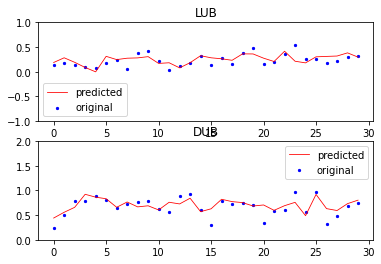

In [328]:
plot_LUB_DUB(y_test, y_pred)

### Evaluation Metrics

#### Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**):

In [329]:
test_evaluation(model, y_pred,results,index)

Test MSE: 0.0157378688454628
Test RMSE: 0.1243947387591858
Test MAE: 0.09312031897182987


***COMMENTS***
> Overfitting was **highly** observed.

In [330]:
index = index +1
results

,Architecture,LR,Dropout and pooling,kernel size,Loss Fn,Train MSE,Validation MSE,Test MSE,Test RMSE,Test MAE
0,CNN 2D,0.0001,"No Dropout Layers, 1 max-pooling layer",1,Mean-Squared-Error,0.021081,0.018341,0.019292,0.138705,0.106015
1,CNN 2D,0.0001,"No Dropout Layers, 3 max-pooling layers",2,Mean-Squared-Error,0.006356,0.022953,0.027629,0.152963,0.123263
2,ANN,0.001,1 Dropout,-,Mean-Squared-Error,0.020477,0.018905,0.018616,0.136401,0.106594
3,ANN,0.001,3 Dropout,-,Mean-Squared-Error,0.02091,0.019591,0.018672,0.136528,0.108438
4,RNN,0.0001,0.05,-,Mean-Squared-Error,0.000087,0.018935,0.020014,0.139957,0.10637
5,RNN (+ layer),0.0001,0.05,-,Mean-Squared-Error,0.00012,0.016496,0.015738,0.124395,0.09312


***COMMENTS***
> We implemented multiple models and changed a lot in them and in all of our time-consuming trials, we didn't reach an MSE lower than the ones we added in our notebook and tabulated above.

> We believe that there might be a chance to get lower MSE but we couldn't reach it or maybe the fault was the regression approach, if we changed it into a classification problem where the labels were `[S1==1, S2==1] `for every location as their index, maybe as an accuracy metric it would be better, but we didn't have time to try it therefore we are not certain.